# Определение стоимости автомобилей

##  Введение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель проекта:**

- Построить модель для определения рыночной стоимости автомобиля. 

*Заказчику важны:*

- качество предсказания;
- скорость предсказания;
- время обучения.

**План выполнения проекта:**


   - Загрузить и изучить данные.
   
   
   - Провести предобработку: заполнить пропуски, обработать аномалии,  удалить неинформативные признаки.
   
   
   - Подготовить выборки для обучения моделей.
   
   
   - Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
   
   
   - Проанализировать время обучения, время предсказания и качество моделей метрикой RMSE. Добиться значения метрики менее 2500. 
   
   
   - Выбрать лучшую модель, опираясь на критерии заказчика.


   - Проверить качество лучшей модели на тестовой выборке.
   
   
   - Написать промежуточный и общий выводы.

**Описание данных:**


   **Признаки:**

   - *DateCrawled — дата скачивания анкеты из базы*
      
   - *VehicleType — тип автомобильного кузова*
      
   - *RegistrationYear — год регистрации автомобиля*
      
   - *Gearbox — тип коробки передач*
      
   - *Power — мощность (л. с.)*
      
   - *Model — модель автомобиля*
      
   - *Kilometer — пробег (км)*
      
   - *RegistrationMonth — месяц регистрации автомобиля*
      
   - *FuelType — тип топлива*
      
   - *Brand — марка автомобиля*
      
   - *Repaired — была машина в ремонте или нет*
      
   - *DateCreated — дата создания анкеты*
      
   - *NumberOfPictures — количество фотографий автомобиля*
      
   - *PostalCode — почтовый индекс владельца анкеты (пользователя)*
      
   - *LastSeen — дата последней активности пользователя*
   
   
   **Целевой признак**
       
   - *Price — цена (евро)*

## Загрузка и изучение данных

In [1]:
#! pip install phik==0.9.7 -q

In [2]:
#! pip install --upgrade scikit-learn -q # -q убирает необязательные выводы в командах Linux

In [3]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import time
import warnings

from sklearn.model_selection import train_test_split 

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler 

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, root_mean_squared_error

# настраиваем отображение 
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 250)
#pd.set_option('max_seq_items', 250)
#pd.set_option('max_colwidth', 20)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [4]:
# загружаем данные
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [5]:
# знакомимся с данными, выводим пять случайных строк, явные и относительные дубликаты и пропуски
def data_info(data):
    d = {'data' : data}
    for a, i in d.items():
        # дубликаты
        print('Датасет:',a,'абсолютное количество явных дубликатов:',i.duplicated().sum())    
        print('Датасет:',a,'относительное количество явных дубликатов:',i.duplicated().sum()/data.shape[0])
        print()
        # пропуски
        print('Датасет:',a,'абсолютное количество пропусков:')
        print(i.isna().sum().sort_values()) 
        print()
        print('Датасет:',a,'относительное количество пропусков:')    
        print((i.isna().sum()/data.shape[0]).sort_values())
        # строки и инфо
        display(i.sample(5))
        print()
        i.info()
# выводим         
data_info(data)  

Датасет: data абсолютное количество явных дубликатов: 4
Датасет: data относительное количество явных дубликатов: 1.1287669068118261e-05

Датасет: data абсолютное количество пропусков:
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
Model                19705
Gearbox              19833
FuelType             32895
VehicleType          37490
Repaired             71154
dtype: int64

Датасет: data относительное количество пропусков:
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen            

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
234136,2016-04-01 20:45:27,550,small,1996,manual,54,twingo,80000,1,petrol,renault,no,2016-04-01 00:00:00,0,96450,2016-04-05 17:45:58
75293,2016-03-18 17:06:23,4250,sedan,2006,manual,105,astra,125000,10,petrol,opel,no,2016-03-18 00:00:00,0,65428,2016-03-29 20:17:37
302889,2016-03-08 17:48:48,990,wagon,1997,NaN,105,NaN,150000,4,petrol,bmw,NaN,2016-03-08 00:00:00,0,70439,2016-04-07 08:15:25
3544,2016-03-22 07:53:11,15450,suv,2011,manual,173,cx_reihe,90000,11,gasoline,mazda,no,2016-03-22 00:00:00,0,26919,2016-04-07 11:17:30
272832,2016-03-20 12:48:06,690,NaN,2017,auto,0,golf,125000,6,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,44801,2016-03-20 12:48:06



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

In [6]:
# выводим строки с полными дубликатами
data[data.duplicated(keep=False)].sort_values(by='DateCrawled')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


In [7]:
# удаляем дубликаты
data.drop_duplicates(inplace=True, ignore_index=True)

#проверяем
print(data.duplicated().sum())
data.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), objec

In [8]:
# смотрим уникальные значения в столбцах с не числовыми данными

# выбираем все столбцы, кроме первого и последнего
data_column = data.iloc[:,1:-1]

columns = data_column.select_dtypes(include='object')
def values_unique(data):
    for column in columns:
        values1 = data[column].unique()
        values2 = data[column].nunique()
        values3 = data[column].value_counts(normalize=True)
        print('Уникальные значения столбца:', column)
        print(values1)
        print('Количество уникальных значений столбца:', column)
        print(values2)
        print('Относительное распределение уникальных значений столбца:', column)
        print(values3)
        print()
    
values_unique(data)      

Уникальные значения столбца: VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество уникальных значений столбца: VehicleType
8
Относительное распределение уникальных значений столбца: VehicleType
sedan          0.288622
small          0.251929
wagon          0.205649
bus            0.090809
convertible    0.063757
coupe          0.051001
suv            0.037857
other          0.010376
Name: VehicleType, dtype: float64

Уникальные значения столбца: Gearbox
['manual' 'auto' nan]
Количество уникальных значений столбца: Gearbox
2
Относительное распределение уникальных значений столбца: Gearbox
manual    0.801863
auto      0.198137
Name: Gearbox, dtype: float64

Уникальные значения столбца: Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b

In [9]:
# смотрим уникальные значения в столбцах с числовыми данными
columns = data.select_dtypes(include='number')
def values_unique(data):
    for column in columns:
        values1 = data[column].unique()
        values2 = data[column].nunique()
        values3 = data[column].value_counts(normalize=True)
        print('Уникальные значения столбца:', column)
        print(values1)
        print('Количество уникальных значений столбца:', column)
        print(values2)
        print('Относительное распределение уникальных значений столбца:', column)
        print(values3)
        print()
        
values_unique(data)      

Уникальные значения столбца: Price
[  480 18300  9800 ... 12395 18429 10985]
Количество уникальных значений столбца: Price
3731
Относительное распределение уникальных значений столбца: Price
0        0.030398
500      0.016000
1500     0.015222
1000     0.013116
1200     0.012964
           ...   
13180    0.000003
10879    0.000003
2683     0.000003
634      0.000003
8188     0.000003
Name: Price, Length: 3731, dtype: float64

Уникальные значения столбца: RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200

   **Особенности и аномалии в столбцах**:
 
 
  - **Repaired:** строковые значения ('yes', 'no') вместо числовых (1/0);

 
  - **Price:** нулевое значение цены и наличие подозрительно низких цен (до 10 евро);

 
  - **RegistrationYear:** много неадекватных значений лет (1000, 5000, 9999 и др.) и наличие "раритетных" значений года (1910, 1915, 1920 и др.); 

 
  - **Power:** нулевое значение мощности и нереально низкие и высокие значения (меньше 10, выше 10000 и др.) ;

 
  - **RegistrationMonth:** нулевое значение месяца;

 
  - **NumberOfPictures:** единственное и нулевое значение;
  
  
  - **Kilometer:** всего тринадцать значений на 354 000 автомобилей.
  
  
Изучим распределение данных.  

In [10]:
# смотрим распределение значений в признаках
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


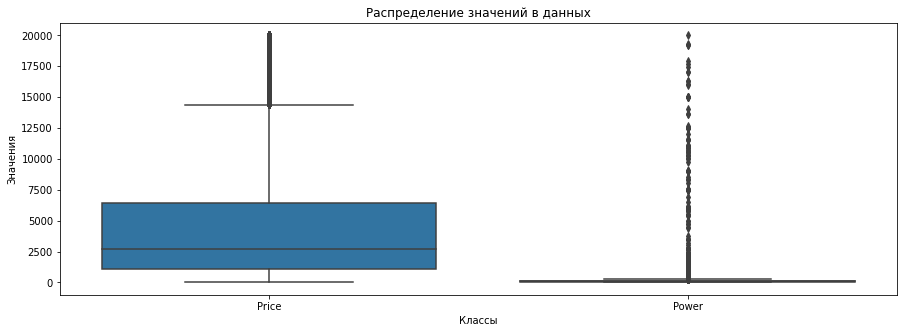

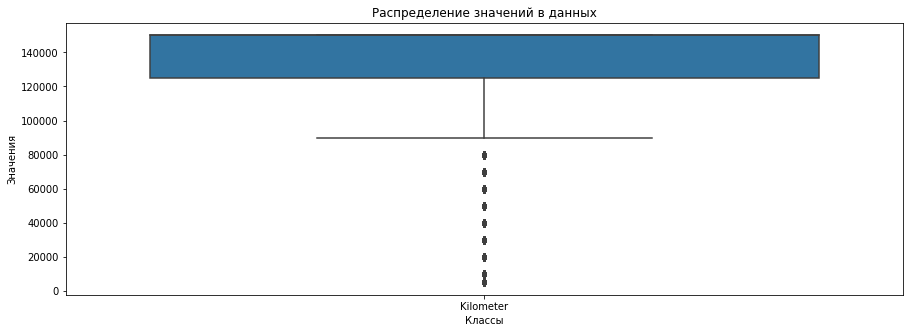

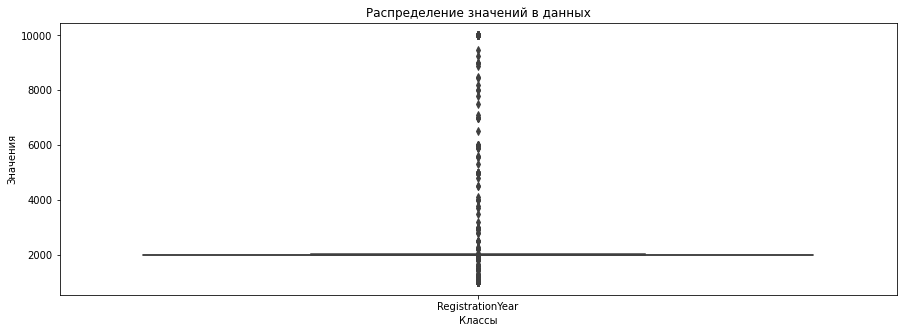

In [11]:
# смотрим разброс данных на диаграмме разброса
def boxplotly(data):
    
    plt.figure(figsize=(15, 5))    
    sns.boxplot(data=data)
    plt.xlabel('Классы')
    plt.ylabel('Значения')
    plt.title('Распределение значений в данных')
    plt.show()   

# смотрим разброс в данных
columns = ['Price','Power']   
boxplotly(data[columns])
columns = ['Kilometer']
boxplotly(data[columns])
columns = ['RegistrationYear'] 
boxplotly(data[columns])

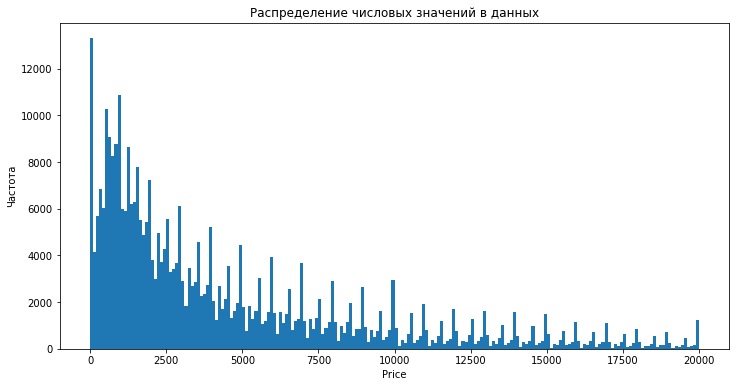

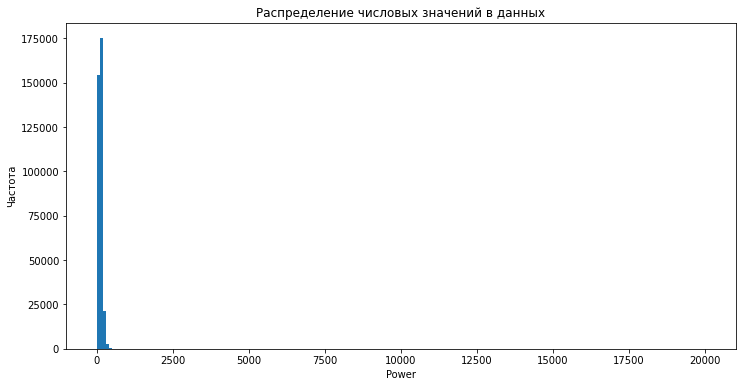

In [12]:
# смотрим столбцы с числовыми данными на гистограмме
columns_plot = ['Price', 'Power']

def plot_hist(data, bins, size):
    for column in columns_plot:
        
        plt.figure(figsize=size)
        data[column].plot(bins=bins, kind='hist')                         
    
        plt.grid=True
        plt.legend=False 
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title('Распределение числовых значений в данных')
        plt.show()       
        
plot_hist(data, 200, (12,6))

Ограничим диапазон значений

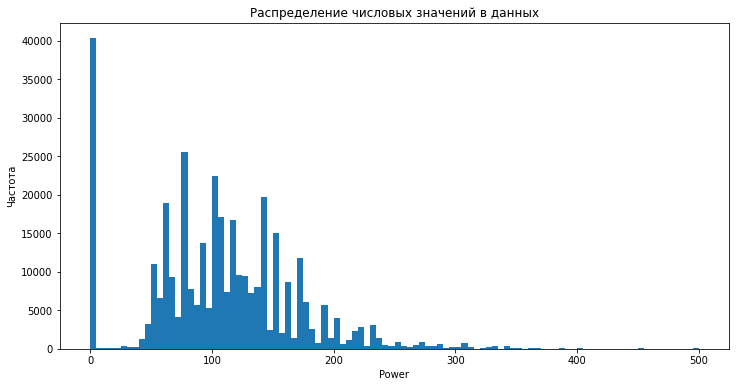

In [13]:
# смотрим столбцы с числовыми данными на гистограмме
# выбираем диапазон
df_power =  data.loc[data['Power']<=500]

# выбираем колонку
columns_plot = ['Power']

# строим график        
plot_hist(df_power, 100, (12,6))

**Вычислим**, какую **долю** данных занимают данные в определенном диапазоне **значений мощности и цены.**

In [14]:
# выбираем диапазон
df_power = data.query('40 <= Power <= 350')
df_price = data.query('100 <= Price <= 12000')

# смотрим долю
print(df_power.shape[0]/data.shape[0],
      df_price.shape[0]/data.shape[0])

0.87905690460401 0.8762970383643983


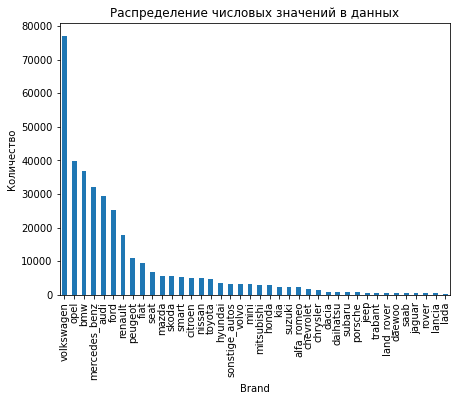

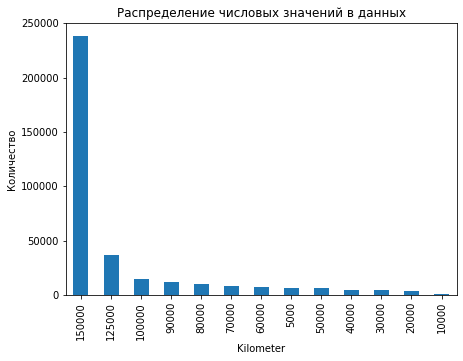

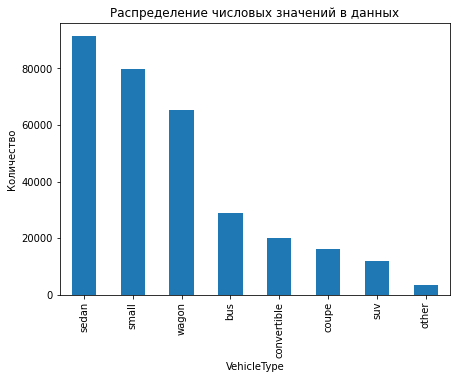

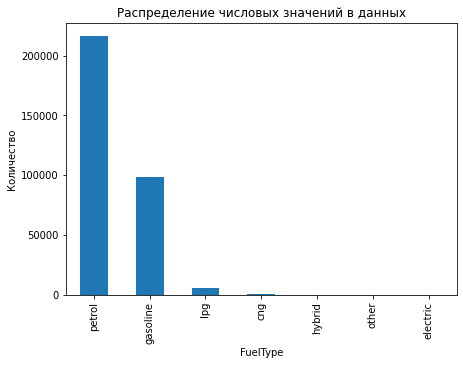

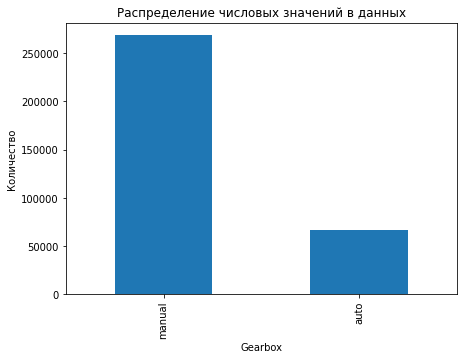

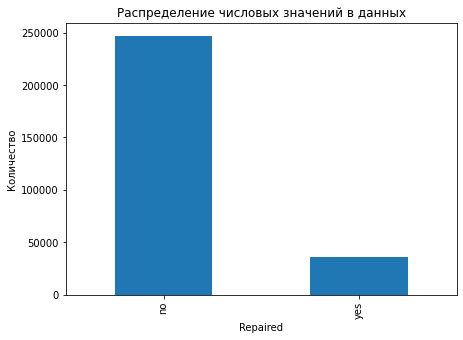

In [15]:
# смотрим столбцы с числовыми  категориальными данными на столбчатых диаграммах
columns_plot = ['Brand', 'Kilometer','VehicleType', 
                'FuelType', 'Gearbox', 'Repaired']

def plot_bar(data, size):
    for column in columns_plot:
        
        plt.figure(figsize=size)
        data[column].value_counts().plot(kind='bar')                         
    
        plt.grid=True        
        plt.legend=False 
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.title('Распределение числовых значений в данных')
        plt.show()       
        
plot_bar(data,(7,5))

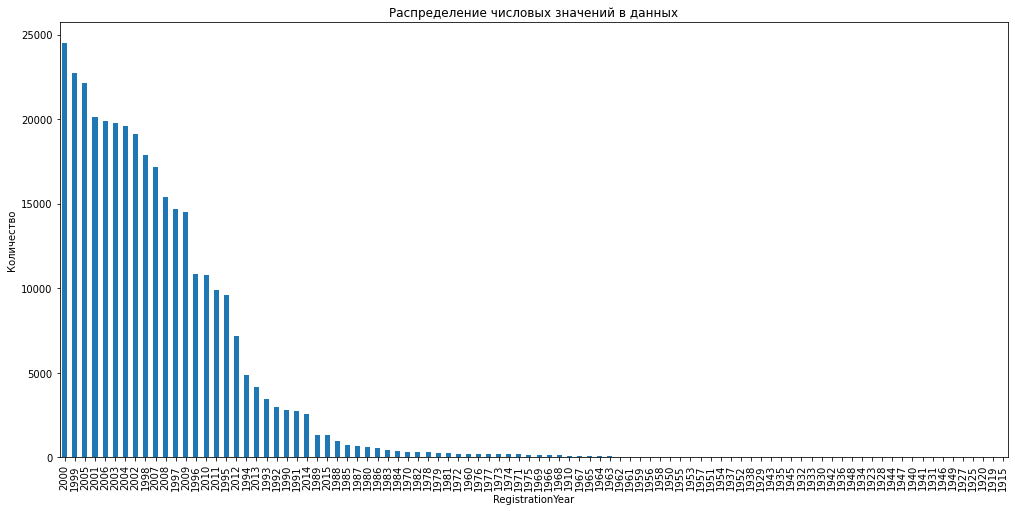

In [16]:
# смотрим столбцы с числовыми  категориальными данными на столбчатой диаграмме
# выбираем диапазон
df_year =  data.query('1900 < RegistrationYear < 2016')

# выбираем колонку
columns_plot = ['RegistrationYear']

# строим график
plot_bar(df_year,(17,8))

Поcторим гистограмму. 

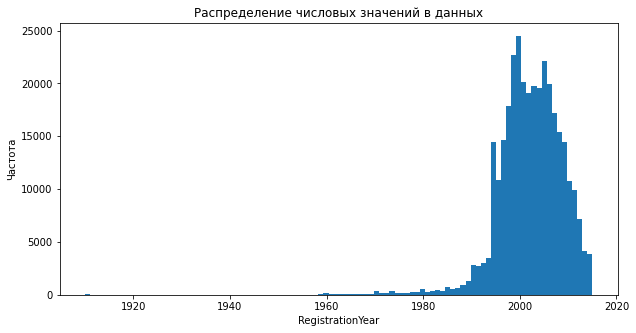

In [17]:
# смотрим столбцы с числовыми данными на гистограмме
# выбираем диапазон
df_year =  data.query('1900 < RegistrationYear < 2016')

# выбираем колонку
columns_plot = ['RegistrationYear']

# строим график
plot_hist(df_year, 100, (10,5))

**Вычислим дату актуальности** - это максимальное значение в столбце DateCrawled.

In [18]:
# приводим данные к типу даты
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])

# получаем дату актуальности 
date_actually  = data['DateCrawled'].max()
print(date_actually )

2016-04-07 14:36:58


**Вычислим**, какую **долю** данных занимают данные в определенном диапазоне **значений даты регистрации.**

Верхняя граница диапазона - год даты актуальности, а нижнюю выберем - 1960, так как раньше этого года встречается крайне мало значений. 

In [19]:
# выбираем диапазон
df_date = data.query('1960 <= RegistrationYear <= 2016')

# смотрим долю
print(df_date.shape[0]/data.shape[0])

0.957806216753912


Посмотрим на количество дней публикации объявления, как **разницу между датой последней активности пользователя** (LastSeen) и **датой создания анкеты** (DateCreated), которая, по идее, не должна превышать дату актуальности, и сопоставим с заявленной стоимостью автомобиля (Price). Возможно, что чем дольше висит объявление о продаже, тем ниже будет цена. С другой стороны, если объявление зависло, это повод задуматься об адекватности цены и исключении таких данных из обучения. 

In [20]:
# приводим данные к типу даты
data['LastSeen'] = pd.to_datetime(data['LastSeen'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

# добавляем столбец с периодом демонстрации объявления
data['days_exposition'] = round((data['LastSeen'] - data['DateCreated'])/ np.timedelta64 ( 1 , 'D'),0)

# проверяем
data['days_exposition'].describe()

count    354365.000000
mean          9.207904
std           8.587628
min           0.000000
25%           3.000000
50%           6.000000
75%          14.000000
max         759.000000
Name: days_exposition, dtype: float64

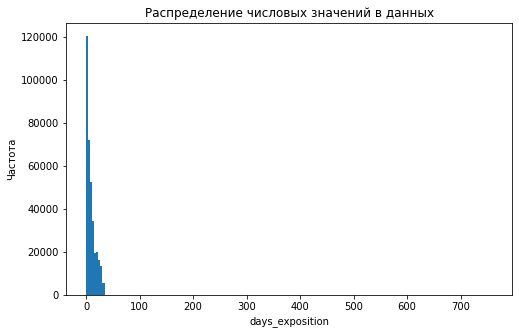

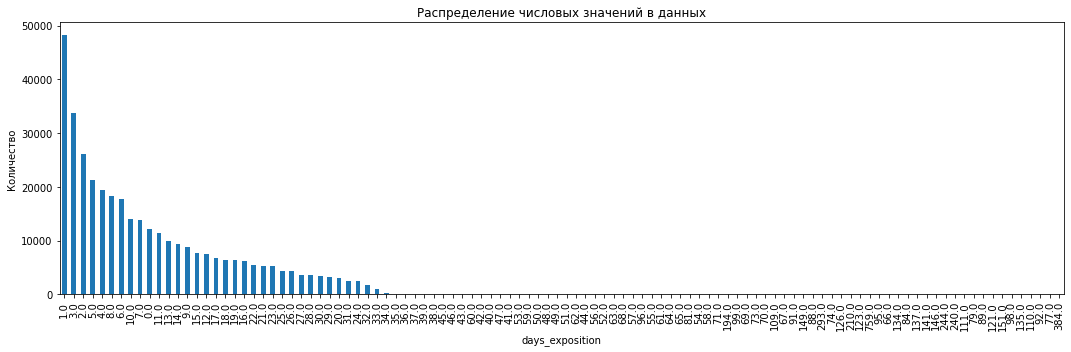

In [21]:
# смотрим столбцы с числовыми данными на гистограмме
# выбираем колонку
columns_plot = ['days_exposition']

# строим график
plot_hist(data, 200, (8,5))
plot_bar(data, (18,5))

In [22]:
# смотрим средние цены в зависимости от количества дней размещения объявления
data.groupby('days_exposition')['Price'].mean()

days_exposition
0.0       3055.582319
1.0       3224.481176
2.0       3455.669407
3.0       4254.487018
4.0       4012.628225
5.0       4486.288955
6.0       4342.818115
7.0       4514.802307
8.0       4671.872381
9.0       4554.131381
10.0      4905.891925
11.0      4935.189372
12.0      4920.394184
13.0      5071.874237
14.0      5001.239957
15.0      5065.028969
16.0      5090.636654
17.0      5158.306343
18.0      5448.188718
19.0      5208.890422
20.0      5149.528365
21.0      5244.730682
22.0      5267.454444
23.0      5402.424052
24.0      5468.697259
25.0      5719.794131
26.0      5557.273534
27.0      5252.699861
28.0      5498.819005
29.0      5507.025802
30.0      5593.561825
31.0      5549.064385
32.0      5698.582106
33.0      5442.184554
34.0      5598.775510
35.0      6197.910448
36.0      7234.071429
37.0      7642.227273
38.0      6435.578947
39.0      6457.545455
40.0      5350.727273
41.0      7309.900000
42.0      8205.363636
43.0      5992.466667
44.0      6508.0

**Вычислим**, какую **долю** данных занимают данные в определенном диапазоне значений **количество дней экспозиции.**

In [23]:
# выбираем диапазон
df_day_exp = data.query('days_exposition <= 35')

# смотрим долю
print(df_day_exp.shape[0]/data.shape[0])

0.9989953861131884


 **Особенности распределения данных**:

- **Price:** основные значения целевой переменной сосредоточены в пределах от 100  до 12000 евро и имеют высокий уровень стандартного отклонения.
 
 
 - **Power:** наибольшее количество значений мощности  находится в пределах от 40 до 350 л.с., остальное похоже на выбросы.  
 
 
 - **Brand:** самый массовый бренд - Фольксваген, самый непопулярный - Лада.
 
 
 - **Kilometer:** самый частый, он же самый большой, пробег - 150000 км, самый нечастый - 10 000 км, все, что ниже 90 000 км - похоже на выбросы. 
 
 
 - **VehicleType**, **FuelType:** наиболее популярный кузов - седан, вид топлива - бензин, электрокары на последнем месте. 
 
 
 - **Gearbox**, **Repaired:** самый популярный вид коробки - ручная, большинство машин в базе - не битые.  Явный дисбаланс классов.
 
 
 - **RegistrationYear:** наиболее часто встречающийся год регистрации автомобиля - 2000. Наибольшая доля автомобилей находится в диапазоне 1960-2016г.
 
 
 - **Самая массовая доля** объявлений имеет **срок** размещения **до 35 дней**. 
 

**Посмотрим** на **корреляцию** признаков перед предобработкой, предварительно ограничив диапазон значений.

In [24]:
# фильтруем диапазон
df_corr = data.query('1960 < RegistrationYear < 2016')
df_corr = df_corr.loc[(data['Power']<=350)&(data['Price']<=15000)]
# удаляем ненужные столбцы
df_corr = df_corr.drop(['DateCrawled','RegistrationMonth','DateCreated', 
                        'PostalCode', 'LastSeen','NumberOfPictures','Model', 
                        'days_exposition'], axis=1)

# проверяем
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314363 entries, 0 to 354364
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             314363 non-null  int64 
 1   VehicleType       301220 non-null  object
 2   RegistrationYear  314363 non-null  int64 
 3   Gearbox           298241 non-null  object
 4   Power             314363 non-null  int64 
 5   Kilometer         314363 non-null  int64 
 6   FuelType          291410 non-null  object
 7   Brand             314363 non-null  object
 8   Repaired          255358 non-null  object
dtypes: int64(4), object(5)
memory usage: 24.0+ MB


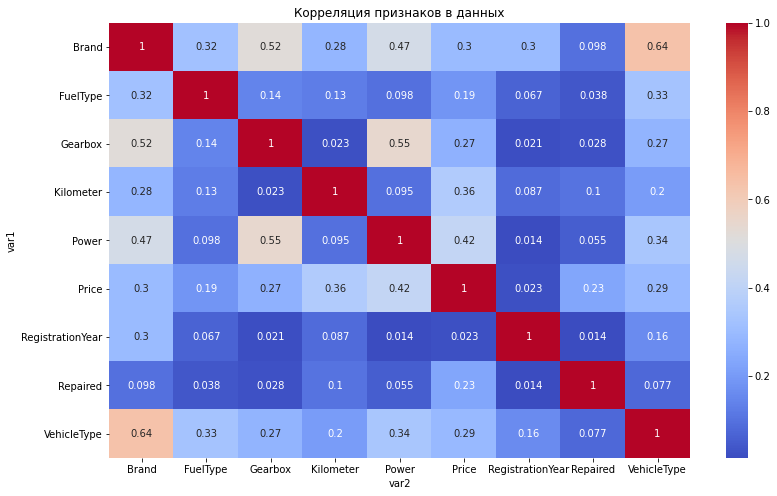

In [25]:
# выбираем интервал
interval_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

# задаем матрицу корреляции
corr_matrix = df_corr.phik_matrix(interval_cols=interval_cols, bins=(2))

# визуализируем матрицу корреляции через тепловую карту
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в данных')
plt.show() 

**Корреляция данных**:


- **Корреляция с целевой переменной** - ценой автомобиля (Price) - в порядке убывания зависимости:  

   - Мощность (Power)
   - Пробег (Kilometer)
   - Бренд (Brand) 
   - Битая/небитая (Repaired)
   - Тип кузова (VehciceType) 
   - Тип коробки (Gearbox)   
   - Тип топлива (FuelType) 
   - Год регистрации (RegisrationYear).


- **Наибольшая взаимная корреляция:**  
   
   - Бренд/Тип кузова 
   - Бренд/Тип коробки 
   - Мощность/Тип коробки 
   - Мощность/Бренд.

**Признаки, влияющие на цену автомобиля:** 

- **VehicleType:** тип машины определяет ее функционал. Чем больше возможностей у машины, тем выше цена.


- **Gearbox:** наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.


- **Power:** мощность двигателя в лошадиных силах (далее л.с.) напрямую влияют на стоимость.


- **Kilometer:** чем выше пробег, тем ниже надежность автомобиля и, соответственно, цена.


- **FuelType:** тип топлива (судя по данным, скорее тип питания) определяет конструкцию двигателя, а следовательно, влияет на цену.


- **Brand:** марка отражает уровень качества и популярность автомобиля и напрямую влияет на цену.


- **Repaired:** автомобили, побывавшие в дтп теряют надежность и ценятся ниже.


- **RegistrationYear:** чем выше возраст, тем ниже цена, зависимость аналогичная пробегу.


- **Model:**  вкупе с типом двигателя и маркой влияет на популярность среди покупателей, а следовательно, и на цену.


- **Другие** признаки **будут неинформативными** для модели с точки зрения влияния на прогнозирование цены.

### Вывод по первому шагу
 
- Загрузили данные, ознакомились, определили пропуски, аномалии, дубликаты и актуальные признаки, изучили распределение и корреляцию.
  
  
  Одно из требований, предъявляемых к модели в этом проекте - **качество предсказания**, поэтому **данные должны быть** максимально **актуальными и адекватными**.  
    
    
**План на предобработку**:

   - **Удалим объявления** со сроком размещения дольше 35 дней. 


   - **Price:** избавимся от выбросов и нулевых значений, отрезав хвост: оставим в датасете только адекватные данные (не более 88%).   
   
   
   - **Model:** заменим пропуски на значение 'unknown'.
   
   
   - **Repaired:** заменим пропуски на значение **'yes'** (автовладельцы, вероятнее всего, умышленно пропускают  этот пункт в анкете, не желая понижать ценность автомобиля в глазах потенциального покупателя; заменим 'yes' и 'no' на 1 и 0, соответственно.


   - **VehicleType**, **FuelType:** и **Gearbox:** восстановим пропущенные значения по популярному типу из столбцов Model и Brand.
   
     
   - **Power:** скорректируем мощность на основе реальных значений: избавимся от выбросов, оставим только актуальные данные.

   
   - **RegistrationYear:** скорректируем данные на основе реальных значений: избавимся от выбросов, оставим только актуальные данные.
   
   
   - **Заменим** числовой **тип данных** на более экономичный.    
   
   
   - **Удалим** неинформативные столбцы: **DateCrawled, LastSeen, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode**, days_exposition.
   
 

## Предобработка

 - Удаляем объявления со сроком размещения дольше 35 дней и избавляемся от выбросов и нулевых значений в столбце Price.

In [26]:
# создаем копию датасета
data_old = data.copy()
# выбираем диапазон
data = data.query('100 <= Price <= 12000')
data = data.query('days_exposition <= 35')
# проверяем
data.info()
data.shape[0]/data_old.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310245 entries, 0 to 354364
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        310245 non-null  datetime64[ns]
 1   Price              310245 non-null  int64         
 2   VehicleType        278661 non-null  object        
 3   RegistrationYear   310245 non-null  int64         
 4   Gearbox            294395 non-null  object        
 5   Power              310245 non-null  int64         
 6   Model              294200 non-null  object        
 7   Kilometer          310245 non-null  int64         
 8   RegistrationMonth  310245 non-null  int64         
 9   FuelType           282840 non-null  object        
 10  Brand              310245 non-null  object        
 11  Repaired           248138 non-null  object        
 12  DateCreated        310245 non-null  datetime64[ns]
 13  NumberOfPictures   310245 non-null  int64   

0.8754956048142452

 - Меняем пропущенные значения в столбцах Model, Repaired, VehicleType, FuelType и Gearbox.

In [27]:
# меняем пропуски в столбце 'Model'
data['Model'].fillna('unknown', inplace=True)

# проверяем
print(data['Model'].isna().sum())

0


In [28]:
# меняем пропуски в столбце 'Repaired'
data['Repaired'].fillna('yes', inplace=True)

# меняем строковые значения на числа 
data['Repaired'] = data['Repaired']. replace ('yes', 1)
data['Repaired'] = data['Repaired']. replace ('no', 0)

# проверяем
print(data['Repaired'].isna().sum())
data['Repaired'].value_counts(normalize=True)

0


0    0.693681
1    0.306319
Name: Repaired, dtype: float64

In [29]:
# создаем функцию по замене пропусков
def fillna_features(column):
    data[column] = data[column].fillna(data
                                       .groupby(['Brand','Model'])[column]
                                       .transform(lambda x: x.value_counts().idxmax())
                                       )
    # прoверяем
    print(data[column].isna().sum())
    print(data[column].value_counts())
    
# заполняем пропуски в столбце VehicleType самым частым значением по признаку Brand и Model    
fillna_features('VehicleType')

0
sedan          93581
small          86987
wagon          60234
bus            28645
convertible    16455
coupe          13040
suv             8410
other           2893
Name: VehicleType, dtype: int64


In [30]:
# заполняем пропуски в столбце FuelType самым частым значением по признаку Brand и Model    
fillna_features('FuelType')

0
petrol      219649
gasoline     84761
lpg           4937
cng            534
other          146
hybrid         146
electric        72
Name: FuelType, dtype: int64


In [31]:
# заполняем пропуски в столбце FuelType самым частым значением по признаку Brand и Model    
fillna_features('Gearbox')

0
manual    257012
auto       53233
Name: Gearbox, dtype: int64


- Оставляем в датасете только актуальные данные столбцов Power.

In [32]:
# выбираем диапазон
data = data.query('40 <= Power <= 350')
# проверяем
data.info()
data.shape[0]/data_old.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274238 entries, 2 to 354364
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        274238 non-null  datetime64[ns]
 1   Price              274238 non-null  int64         
 2   VehicleType        274238 non-null  object        
 3   RegistrationYear   274238 non-null  int64         
 4   Gearbox            274238 non-null  object        
 5   Power              274238 non-null  int64         
 6   Model              274238 non-null  object        
 7   Kilometer          274238 non-null  int64         
 8   RegistrationMonth  274238 non-null  int64         
 9   FuelType           274238 non-null  object        
 10  Brand              274238 non-null  object        
 11  Repaired           274238 non-null  int64         
 12  DateCreated        274238 non-null  datetime64[ns]
 13  NumberOfPictures   274238 non-null  int64   

0.7738856828411383

- Оставляем в датасете только актуальные данные столбцов RegistrationYear.

In [33]:
# выбираем диапазон для обучения 
data = data.query('1960 <= RegistrationYear <= 2016')

# проверяем
data.info()
data.shape[0]/data_old.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264452 entries, 2 to 354364
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        264452 non-null  datetime64[ns]
 1   Price              264452 non-null  int64         
 2   VehicleType        264452 non-null  object        
 3   RegistrationYear   264452 non-null  int64         
 4   Gearbox            264452 non-null  object        
 5   Power              264452 non-null  int64         
 6   Model              264452 non-null  object        
 7   Kilometer          264452 non-null  int64         
 8   RegistrationMonth  264452 non-null  int64         
 9   FuelType           264452 non-null  object        
 10  Brand              264452 non-null  object        
 11  Repaired           264452 non-null  int64         
 12  DateCreated        264452 non-null  datetime64[ns]
 13  NumberOfPictures   264452 non-null  int64   

0.7462700887502999

- Заменим числовой тип данных на более экономичный.

In [34]:
# меняем тип данных с 64 на 32
def change_type(columns, type):
    data[columns
        ] = data[columns].astype(type)
    return data 
data = change_type(data.columns[[1,3,5,7,11]],'int32')

# проверяем
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264452 entries, 2 to 354364
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        264452 non-null  datetime64[ns]
 1   Price              264452 non-null  int32         
 2   VehicleType        264452 non-null  object        
 3   RegistrationYear   264452 non-null  int32         
 4   Gearbox            264452 non-null  object        
 5   Power              264452 non-null  int32         
 6   Model              264452 non-null  object        
 7   Kilometer          264452 non-null  int32         
 8   RegistrationMonth  264452 non-null  int64         
 9   FuelType           264452 non-null  object        
 10  Brand              264452 non-null  object        
 11  Repaired           264452 non-null  int32         
 12  DateCreated        264452 non-null  datetime64[ns]
 13  NumberOfPictures   264452 non-null  int64   

In [35]:
# удаляем лишние столбцы
data = data.drop(['DateCrawled', 'LastSeen', 'RegistrationMonth', 
                  'DateCreated', 'NumberOfPictures', 'PostalCode',
                 'days_exposition'], axis=1)

# сбросываем индексы
data.reset_index(drop=True, inplace=True)

# проверяем
print(data.shape)
data.info()

(264452, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264452 entries, 0 to 264451
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             264452 non-null  int32 
 1   VehicleType       264452 non-null  object
 2   RegistrationYear  264452 non-null  int32 
 3   Gearbox           264452 non-null  object
 4   Power             264452 non-null  int32 
 5   Model             264452 non-null  object
 6   Kilometer         264452 non-null  int32 
 7   FuelType          264452 non-null  object
 8   Brand             264452 non-null  object
 9   Repaired          264452 non-null  int32 
dtypes: int32(5), object(5)
memory usage: 15.1+ MB


 - После обработки и удаления части данных, еще раз проверим наличие дубликатов  и, если обнаружим, избавимся от них.

In [36]:
# смотрим дубликаты 
data.duplicated().sum()

39919

In [37]:
# удаляем дубликаты и сбрасываем индексы
data.drop_duplicates(inplace=True, ignore_index=True)

#проверяем
print(data.duplicated().sum())
data.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224533 entries, 0 to 224532
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             224533 non-null  int32 
 1   VehicleType       224533 non-null  object
 2   RegistrationYear  224533 non-null  int32 
 3   Gearbox           224533 non-null  object
 4   Power             224533 non-null  int32 
 5   Model             224533 non-null  object
 6   Kilometer         224533 non-null  int32 
 7   FuelType          224533 non-null  object
 8   Brand             224533 non-null  object
 9   Repaired          224533 non-null  int32 
dtypes: int32(5), object(5)
memory usage: 12.8+ MB


### Вывод по  второму  шагу

- **Обработали пропуски и аномалии**, оставили в датасете только актуальные признаки и адекватные значения. Удалили появившиеся дубликаты.
  

**План на подготовку к обучению модели**:

- Разделим данные на выборки: обучающую, валидационную, тестовую.


- Закодируем категориальные признаки методом OHE и OE.


- Обработаем выбросы StandartScaler.


## Подготовка данных

In [38]:
# формируем выборки и выделяем цель и признаки: 
# выделяем цель и признаки
target = data['Price']
features = data.drop('Price', axis=1)

# формируем выборки: обучающую(75%) валидационную(12,5%) и тестовую(12,5%)
features_train, features_test1, target_train, target_test1 = train_test_split(features,
                                target,
                                test_size=0.25,
                                random_state=12345)

features_test, features_valid, target_test, target_valid  = train_test_split(features_test1,
                                target_test1,
                                test_size=0.5,
                                random_state=12345) 

# проверяем
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(168399, 9)
(168399,)
(28067, 9)
(28067,)
(28067, 9)
(28067,)


 - Закодируем категориальные признаки для Линейных моделей методом OHE.

In [39]:
# задаем категориальные признаки для кодировки
ohe_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

# задаем численные признаки для масштабирования
num_features = ['RegistrationYear', 'Power', 'Kilometer']

In [40]:
# задаем переменные для OHE
features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

In [41]:
# активируем кодировщик категориальных признаков
encoder_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_ohe[ohe_features])

# кодируем категориальные признаки
features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[ohe_features])

# удаляем лишние колонки 
features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

# проверяем
print(features_train_ohe.shape)

(168399, 303)


In [42]:
# кодируем категориальные признаки в валидационой выборке, кодировщиком, обученным на тренировочной
features_valid_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid_ohe[ohe_features])

# удаляем лишние колонки 
features_valid_ohe = features_valid_ohe.drop(ohe_features, axis=1)

# проверяем
print(features_valid_ohe.shape)

(28067, 303)


In [43]:
# кодируем категориальные признаки в тестовом наборе, кодировщиком, обученным на тренировочной
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[ohe_features])

# удаляем лишние колонки 
features_test_ohe = features_test_ohe.drop(ohe_features, axis=1)

# проверяем
print(features_test_ohe.shape)

(28067, 303)


- Проведем масштабирование признаков.

In [44]:
# масштабируем численные признаки 
scaler = StandardScaler()
scaler.fit(features_train_ohe[num_features])
features_train_ohe[num_features] = scaler.transform(features_train_ohe[num_features])
features_valid_ohe[num_features] = scaler.transform(features_valid_ohe[num_features])
features_test_ohe[num_features] = scaler.transform(features_test_ohe[num_features])

# проверяем размер итоговых выборок
print(features_train_ohe.shape) 
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(168399, 303)
(28067, 303)
(28067, 303)


- Закодируем категориальные признаки для Бустинга методом OrdinalEncoder.

In [45]:
# задаем переменные для OE
features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()
features_test_oe = features_test.copy()

In [46]:
# активируем кодировщик категориальных признаков
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=249)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_oe.fit(features_train_oe[ohe_features])

# кодируем категориальные признаки
features_train_oe[
    encoder_oe.get_feature_names_out()
] = encoder_oe.transform(features_train_oe[ohe_features])

# проверяем
print(features_train_oe.shape)

(168399, 9)


In [47]:
# кодируем категориальные признаки в валидационой выборке, кодировщиком, обученным на тренировочной
features_valid_oe[
    encoder_oe.get_feature_names_out()
] = encoder_oe.transform(features_valid_oe[ohe_features])

# проверяем
print(features_valid_oe.shape)

(28067, 9)


In [48]:
# кодируем категориальные признаки в тестовом наборе, кодировщиком, обученным на тренировочной
features_test_oe[
    encoder_oe.get_feature_names_out()
] = encoder_oe.transform(features_test_oe[ohe_features])

# проверяем
print(features_test_oe.shape)

(28067, 9)


- Проведем масштабирование признаков.

In [49]:
# масштабируем численные признаки 
scaler = StandardScaler()
scaler.fit(features_train_oe[num_features])
features_train_oe[num_features] = scaler.transform(features_train_oe[num_features])
features_valid_oe[num_features] = scaler.transform(features_valid_oe[num_features])
features_test_oe[num_features] = scaler.transform(features_test_oe[num_features])

# проверяем размер итоговых выборок
print(features_train_oe.shape) 
print(features_valid_oe.shape)
print(features_test_oe.shape)

(168399, 9)
(28067, 9)
(28067, 9)


### Вывод по третьему  шагу

- Разделили датасет на выборки (обучающую - 75%, валидационную - 12,5%, и тестовую - 12,5% ), обработали категориальные и числовые признаки по-разному для разных моделей.
  

## Обучение моделей

- Проводим обучение моделей и получаем предсказания с параметрами по умолчанию, фиксируя время операций.

In [50]:
# создаем функцию работы моделей
def RMSE_price(model, features_train, features_valid, target):
    
    # фиксируем время начала обучения
    start_time_fit = time.time() 
    # обучаем модель
    model.fit(features_train, target_train) 
    # фиксируем время конца обучения и общее время
    end_time_fit = time.time()
    full_time_fit = round(end_time_fit - start_time_fit,3)
    
    # фиксируем время начала выполнения предсказания
    start_time_predict = time.time()
    # получаем предсказание
    predicted_valid = model.predict(features_valid)
    predicted_valid_mean = predicted_valid.mean()
    rmse = root_mean_squared_error(target, predicted_valid)
    # фиксируем время конца выполнения предсказания и общее время
    end_time_predict = time.time()
    full_time_predict = round(end_time_predict - start_time_predict,3)
    
    return predicted_valid_mean, rmse, full_time_fit, full_time_predict

In [51]:
%%time 
# активируем модель 
model_LR = LinearRegression()
# получаем предсказание Линейной регрессии на валидационной выборке
pred_valid_mean_LR, rmse_LR, time_fit_LR, time_predict_LR = RMSE_price(model_LR,
                                                                       features_train_ohe, 
                                                                       features_valid_ohe,
                                                                       target_valid)
# выводим итоговые показатели 
print('Средняя цена, предсказанная LinearRegression:', pred_valid_mean_LR,', RMSE =',rmse_LR)
print(f"Время обучения LinearRegression: {time_fit_LR} секунд")
print(f"Время предсказания LinearRegression: {time_predict_LR} секунд")

Средняя цена, предсказанная LinearRegression: 3784.1354686341215 , RMSE = 1894.937127059451
Время обучения LinearRegression: 16.369 секунд
Время предсказания LinearRegression: 0.229 секунд
CPU times: user 12.7 s, sys: 3.95 s, total: 16.6 s
Wall time: 16.6 s


In [52]:
%%time
# активируем модель 
model_LGBMR = LGBMRegressor(random_state=12345)
# получаем предсказание LGBMRegressor на валидационной выборке
pred_valid_mean_LGBMR, rmse_LGBMR, time_fit_LGBMR, time_predict_LGBMR = RMSE_price(model_LGBMR,
                                                                                   features_train_oe, 
                                                                                   features_valid_oe,
                                                                                   target_valid)
#выводим итоговые показатели 
print('Средняя цена, предсказанная LGBMRegressor:', pred_valid_mean_LGBMR,', RMSE =',rmse_LGBMR)
print(f"Время обучения LGBMRegressor: {time_fit_LGBMR} секунд")
print(f"Время предсказания LGBMRegressor: {time_predict_LGBMR} секунд")

Средняя цена, предсказанная LGBMRegressor: 3753.953942861009 , RMSE = 1288.4572274915563
Время обучения LGBMRegressor: 8.002 секунд
Время предсказания LGBMRegressor: 0.298 секунд
CPU times: user 8.05 s, sys: 125 ms, total: 8.18 s
Wall time: 8.3 s


In [53]:
%%time
# активируем модель 
model_CBR = CatBoostRegressor(verbose=0,random_state=12345)
# получаем предсказание CatBoostRegressor на валидационной выборке
pred_valid_mean_CBR, rmse_CBR, time_fit_CBR, time_predict_CBR = RMSE_price(model_CBR,
                                                                           features_train_oe, 
                                                                           features_valid_oe,
                                                                           target_valid)
#выводим итоговые показатели 
print('Средняя цена, предсказанная CatBoostRegressor:', pred_valid_mean_CBR,', RMSE =',rmse_CBR)
print(f"Время обучения CatBoostRegressor: {time_fit_CBR} секунд")
print(f"Время предсказания CatBoostRegressor: {time_predict_CBR} секунд")

Средняя цена, предсказанная CatBoostRegressor: 3754.3328197140886 , RMSE = 1243.3180062780305
Время обучения CatBoostRegressor: 24.603 секунд
Время предсказания CatBoostRegressor: 0.03 секунд
CPU times: user 23.3 s, sys: 109 ms, total: 23.4 s
Wall time: 24.6 s


In [54]:
# создаем таблицу с результатами работы моделей
df={'model':  ['LinRegression',
               'LGBMReg',
               'CatBoostReg'],
    
    'RMSE':  [rmse_LR,
              rmse_LGBMR,
              rmse_CBR],
    
    'predict_price_mean': [pred_valid_mean_LR,
                           pred_valid_mean_LGBMR,
                           pred_valid_mean_CBR],
   
    'fit_time': [time_fit_LR,
                 time_fit_LGBMR,
                 time_fit_CBR],
    
    'predict_time':[time_predict_LR,
                    time_predict_LGBMR,
                    time_predict_CBR]}


# выводим результаты
scores_model_def = pd.DataFrame(df).sort_values(by='RMSE')
scores_model_def

,model,RMSE,predict_price_mean,fit_time,predict_time
2,CatBoostReg,1243.318006,3754.332820,24.603,0.030
1,LGBMReg,1288.457227,3753.953943,8.002,0.298
0,LinRegression,1894.937127,3784.135469,16.369,0.229


- **Наилучшие показатели RMSE** и **времени предсказания** с параметрами по умолчанию **у модели CatBoostRegression**. Намного **быстрее всех** обучилась **LightGBMRegressor**.

- Подберем **гиперпараметры** методом **HalvingRandomSearchCV** и проверим качество предсказаний моделей с новыми гиперпараметрами.

In [55]:
%%time
# подбираем гиперпараметры для Линейной регрессии

# активируем модель
model_LR_HCV = LinearRegression()

# задаем область поиска гиперпараметров
parametrs =  { 'n_jobs': [1, -1],
              'fit_intercept': [True, False],
              'copy_X':[True, False]
              }

# активируем поиск и запускаем обучение
HCV_LR = HalvingRandomSearchCV(model_LR_HCV, 
                               parametrs,
                               cv=10,
                               n_jobs=-1, 
                               factor=2,
                               max_resources=80,
                               scoring='neg_root_mean_squared_error',
                               random_state = 12345,
                               verbose=1)

HCV_LR.fit(features_train_ohe, target_train)

# выводим найденные гиперпараметры
display(HCV_LR.best_params_) 

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits


{'n_jobs': 1, 'fit_intercept': True, 'copy_X': True}

CPU times: user 17.1 s, sys: 7.98 s, total: 25.1 s
Wall time: 25.1 s


In [56]:
%%time
# получаем предсказание LinearRegression с выбранными гиперпараметрами на валидационной выборке 
pred_valid_mean_LR_hcv, rmse_LR_hcv, \
       time_fit_LR_hcv, time_predict_LR_hcv = RMSE_price(HCV_LR.best_estimator_,
                                                                features_train_ohe, 
                                                                features_valid_ohe,
                                                                target_valid)
#выводим итоговые показатели 
print('Средняя цена, предсказанная LinearRegression:', pred_valid_mean_LR_hcv,', RMSE =',rmse_LR_hcv)
print(f"Время обучения LinearRegression: {time_fit_LR_hcv} секунд")
print(f"Время предсказания LinearRegression: {time_predict_LR_hcv} секунд")

Средняя цена, предсказанная LinearRegression: 3784.1354686341215 , RMSE = 1894.937127059451
Время обучения LinearRegression: 16.604 секунд
Время предсказания LinearRegression: 0.188 секунд
CPU times: user 13 s, sys: 3.81 s, total: 16.8 s
Wall time: 16.8 s


In [57]:
%%time
# подбираем гиперпараметры для LGBMRegressor

# активируем модель
model_LGBMR_HCV = LGBMRegressor(random_state=12345)

# задаем область поиска гиперпараметров
parametrs = {'max_depth':  range(8,12),
             'learning_rate': [0.1, 0.3, 0.5],
             'n_estimators': range(100, 600, 100)
            }
# активируем поиск и запускаем обучение
HCV_LGBMR = HalvingRandomSearchCV(model_LGBMR_HCV, 
                                  parametrs,
                                  cv=10,
                                  n_jobs=-1, 
                                  factor=2,
                                  max_resources=80,
                                  scoring='neg_root_mean_squared_error',
                                  random_state = 9912345,
                                  verbose=1)

HCV_LGBMR.fit(features_train_oe, target_train, eval_metric='rmse')

# выводим найденные гиперпараметры
display(HCV_LGBMR.best_params_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits


{'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.5}

CPU times: user 30.8 s, sys: 427 ms, total: 31.2 s
Wall time: 32.1 s


In [58]:
%%time
# получаем предсказание LGBMRegressor с выбранными гиперпараметрами на валидационной выборке 
pred_valid_mean_LGBMR_hcv, \
rmse_LGBMR_hcv, time_fit_LGBMR_hcv, time_predict_LGBMR_hcv = RMSE_price(HCV_LGBMR.best_estimator_,
                                                                                features_train_oe, 
                                                                                features_valid_oe,
                                                                                target_valid)
#выводим итоговые показатели 
print('Средняя цена, предсказанная LGBMRegressor:', pred_valid_mean_LGBMR_hcv,', RMSE =',rmse_LGBMR_hcv)
print(f"Время обучения LGBMRegressor: {time_fit_LGBMR_hcv} секунд")
print(f"Время предсказания LGBMRegressor: {time_predict_LGBMR_hcv} секунд")

Средняя цена, предсказанная LGBMRegressor: 3753.7873952555237 , RMSE = 1247.9124747712629
Время обучения LGBMRegressor: 11.491 секунд
Время предсказания LGBMRegressor: 0.406 секунд
CPU times: user 11.7 s, sys: 74.4 ms, total: 11.8 s
Wall time: 12 s


In [59]:
%%time
# подбираем гиперпараметры для CatBoost

# активируем модель
model_CBR_HCV = CatBoostRegressor(random_state=12345)

# задаем область поиска гиперпараметров
parametrs = {'iterations': range(100, 600, 100),
             'depth':  range(8,12),
             'learning_rate': [0.1, 0.3, 0.5]
            }
# активируем поиск и запускаем обучение
HCV_CBR = HalvingRandomSearchCV(model_CBR_HCV, 
                                parametrs,
                                cv=10,
                                n_jobs=-1, 
                                factor=2, 
                                max_resources=80,
                                scoring='neg_root_mean_squared_error',
                                random_state = 12345,
                                verbose=1)

HCV_CBR.fit(features_train_oe, target_train, verbose=False)

# выводим найденные гиперпараметры для СatBoost
best_iterations_СBR = HCV_CBR.best_params_.get('iterations')
best_depth_СBR = HCV_CBR.best_params_.get('depth')
best_learning_rate_СBR = HCV_CBR.best_params_.get('learning_rate')

display(HCV_CBR.best_params_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits


{'learning_rate': 0.5, 'iterations': 200, 'depth': 11}

CPU times: user 32.8 s, sys: 1.03 s, total: 33.8 s
Wall time: 1min 24s


In [60]:
%%time
# получаем предсказание CatBoostRegressor с выбранными гиперпараметрами на валидационной выборке 
model_CBR_HCV = CatBoostRegressor(random_state=12345, 
                  depth=best_depth_СBR,
                  learning_rate=best_learning_rate_СBR,
                  iterations=best_iterations_СBR,
                  verbose=0)

pred_valid_mean_CBR_hcv, \
rmse_CBR_hcv, time_fit_CBR_hcv, time_predict_CBR_hcv = RMSE_price(model_CBR_HCV,
                                                                  features_train_oe, 
                                                                  features_valid_oe,
                                                                  target_valid)

#выводим итоговые показатели 
print('Средняя цена, предсказанная CatBoostRegressor:', pred_valid_mean_CBR_hcv,'RMSE =',rmse_CBR_hcv)
print(f"Время обучения CatBoostRegressor: {time_fit_CBR_hcv} секунд")
print(f"Время предсказания CatBoostRegressor: {time_predict_CBR_hcv} секунд")

Средняя цена, предсказанная CatBoostRegressor: 3754.0687338677035 RMSE = 1240.9342136191797
Время обучения CatBoostRegressor: 13.152 секунд
Время предсказания CatBoostRegressor: 0.03 секунд
CPU times: user 11.7 s, sys: 44.6 ms, total: 11.7 s
Wall time: 13.2 s


In [61]:
# создаем таблицу с результатами работы моделей
df={'model':  ['LinRegression',
               'LGBMReg',
               'CatBoostReg'],
    
    'RMSE':  [rmse_LR_hcv,
              rmse_LGBMR_hcv,
              rmse_CBR_hcv],
    
    'predict_price_mean': [pred_valid_mean_LR_hcv, 
                           pred_valid_mean_LGBMR_hcv,
                           pred_valid_mean_CBR_hcv],
   
    'fit_time': [time_fit_LR_hcv,
                 time_fit_LGBMR_hcv,
                 time_fit_CBR_hcv],
    
    'predict_time':[time_predict_LR_hcv,
                    time_predict_LGBMR_hcv,
                    time_predict_CBR_hcv]}


# выводим результаты
scores_model_hcv = pd.DataFrame(df).sort_values(by='RMSE')
scores_model_hcv

,model,RMSE,predict_price_mean,fit_time,predict_time
2,CatBoostReg,1240.934214,3754.068734,13.152,0.030
1,LGBMReg,1247.912475,3753.787395,11.491,0.406
0,LinRegression,1894.937127,3784.135469,16.604,0.188


### Вывод по четвертому шагу

- **Обучили модели**: LinearRegression, LightGBMRegressor и CatBoostRegressor и проверили их предсказание на валидационной выборке.


- **Подобрали** моделям **гиперпараметры**. 


- **Проверили качество** предсказания моделей **метрикой RMSE**.


- **Лучше** всех **предсказала цену CatBoostRegressor** с подобранными гиперпараметрами. Она же **показала лучшее время предсказания**. 


- **Быстрее** всех справилась **с задачей обучения LightGBMRegressor**. 

## Анализ моделей

- **Составим рейтинг моделей** на основании полученных оценок.


- Заказчик не указал значимости каждого параметра, однако, здравый смысл подсказывает, что **качество предсказания - самый важный показатель**, ведь если модель будет работать быстро, но неточно, это вызовет негативную реакцию пользователей, так же, **как** медленная **скорость предсказания**, а вот **скорость обучения может иметь меньший вес**, так как обучается модель на другом датасете. 


- **Присвоим** каждому из трех параметров **свой вес**: качеству предсказания - 0.4; времени предсказания - 0.35; времени обучения - 0.25. 

In [62]:
# создаем датафрейм с показателями моделей с гипрепараметрами и присваиваем им рейтинг
scores_model_def['RMSE_rating'] = (scores_model_def['RMSE'].min()/
                                   scores_model_def['RMSE'])

scores_model_def['fit_time_rating'] = (scores_model_def['fit_time'].min()/
                                       scores_model_def['fit_time'])

scores_model_def['predict_time_rating'] = (scores_model_def['predict_time'].min()/
                                           scores_model_def['predict_time'])

scores_model_def['final_rating'] = ((scores_model_def['fit_time_rating']*.25+
                                    scores_model_def['predict_time_rating']*.35+
                                    scores_model_def['RMSE_rating']*.4)*10)
# смотрим результат
scores_model_def.sort_values(by='final_rating', ascending=False)

,model,RMSE,predict_price_mean,fit_time,predict_time,RMSE_rating,fit_time_rating,predict_time_rating,final_rating
2,CatBoostReg,1243.318006,3754.332820,24.603,0.030,1.000000,0.325245,1.000000,8.313112
1,LGBMReg,1288.457227,3753.953943,8.002,0.298,0.964966,1.000000,0.100671,6.712215
0,LinRegression,1894.937127,3784.135469,16.369,0.229,0.656126,0.488851,0.131004,4.305148


In [63]:
# создаем датафрейм с показателями моделей с гипрепараметрами и присваиваем им рейтинг
scores_model_hcv['RMSE_rating'] = (scores_model_hcv['RMSE'].min()/
                                   scores_model_hcv['RMSE'])

scores_model_hcv['fit_time_rating'] = (scores_model_hcv['fit_time'].min()/
                                       scores_model_hcv['fit_time'])

scores_model_hcv['predict_time_rating'] = (scores_model_hcv['predict_time'].min()/
                                           scores_model_hcv['predict_time'])

scores_model_hcv['final_rating'] = ((scores_model_hcv['fit_time_rating']*.25+
                                    scores_model_hcv['predict_time_rating']*.35+
                                    scores_model_hcv['RMSE_rating']*.4)*10)
# смотрим результат
scores_model_hcv.sort_values(by='final_rating', ascending=False)

,model,RMSE,predict_price_mean,fit_time,predict_time,RMSE_rating,fit_time_rating,predict_time_rating,final_rating
2,CatBoostReg,1240.934214,3754.068734,13.152,0.030,1.000000,0.873707,1.000000,9.684269
1,LGBMReg,1247.912475,3753.787395,11.491,0.406,0.994408,1.000000,0.073892,6.736253
0,LinRegression,1894.937127,3784.135469,16.604,0.188,0.654868,0.692062,0.159574,4.908139


### Вывод по пятому шагу

- **Составили рейтинг моделей**  с разными гиперпараметрами по полученным оценкам в ходе обучения на обучающей выборке и предсказывания на валидацинной.


-  **Самый высокий рейтинг** показала модель **CatBoostRegressor** с подобранными гиперпараметрами (depth=11, iterations=200, learning_rate=0.5): она **дала более точное предсказание** (наименьший из всех уровень ошибки **RMSE - 1240.**) и **быстрее** других **предсказывала (0.03c)**, хотя и обучалась медленнее, чем  LightGBMRegressor.

 ## Проверка лучшей модели на тестовой выборке

- Проверим работу победившей модели на тестовой выборке. 

In [64]:
%%time
# получаем предсказание CatBoostRegressor на тестовой выборке
pred_valid_mean_CBR, rmse_CBR, time_fit_CBR, time_predict_CBR = RMSE_price(model_CBR_HCV,
                                                                           features_train_oe, 
                                                                           features_test_oe,
                                                                           target_test)
#выводим итоговые показатели 
print('Средняя цена, предсказанная CatBoostRegressor:', pred_valid_mean_CBR,'RMSE =',rmse_CBR)
print(f"Время обучения CatBoostRegressor: {time_fit_CBR} секунд")
print(f"Время предсказания CatBoostRegressor: {time_predict_CBR} секунд")

Средняя цена, предсказанная CatBoostRegressor: 3766.383792573986 RMSE = 1230.5394713948986
Время обучения CatBoostRegressor: 12.403 секунд
Время предсказания CatBoostRegressor: 0.026 секунд
CPU times: user 11.7 s, sys: 29.8 ms, total: 11.7 s
Wall time: 12.4 s


### Вывод по шестому шагу

- Модель не переобучилась, показав на тестовой выборке результат лучше, чем на валидационной.

## Общий вывод

- В процессе работы над проектом мы:

   - Загрузили и изучили данные;
   - Провели предобработку: заполнили пропуски, обработали аномалии, удалили неинформативные признаки;
   - Подготовили выборки для обучения моделей.;
   - Обучили разные модели: LinearRegression, LightGBMRegressor и CatBoostRegressor. Для каждой модели попробовали разные гиперпараметры;
   - Проанализировали время обучения, время предсказания и качество моделей метрикой RMSE. Добились значения метрики менее 2500;
   - Выбрали лучшую модель, опираясь на критерии заказчика;
   
   - Проверили качество лучшей модели на тестовой выборке.


- **Резюме:**

  - **Лучше других** с задачей **справилась модель CatBoostRegressor**, показав **лучшее качество предсказания**, **самое быстрое время предсказания** и второе время обучения. Модель смело **можно рекомендовать к использованию**.  